(GLM-simpsons-paradox)=
# Simpson's paradox

:::{post} September, 2024
:tags: regression, hierarchical model, linear model, posterior predictive, causal inference, Simpson's paradox 
:category: beginner
:author: Benjamin T. Vincent
:::

[Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox) describes a situation where there might be a negative relationship between two variables within a group, but when data from multiple groups are combined, that relationship may disappear or even reverse sign. The gif below (from the Simpson's Paradox [Wikipedia](https://en.wikipedia.org/wiki/Simpson%27s_paradox) page) demonstrates this very nicely.

![](https://upload.wikimedia.org/wikipedia/commons/f/fb/Simpsons_paradox_-_animation.gif)

Another way of describing this is that we wish to causally estimate the effect of a predictor variable $x$ on an outcome variable $y$. The seemingly obvious approach of modelling `y ~ 1 + x` will lead us to conclude (in the situation above) that increasing $x$ causes $y$ to decrease (see Model 1 below). However, the relationship between $x$ and $y$ is confounded by a group membership variable $group$. This group membership variable $g$ is not included in the model, and so the relationship between $x$ and $y$ is biased. In some situations (e.g. the image above) this can lead us to completely reverse the sign of our estimate of the causal effect, now estimating that increasing $x$ causes $y$ to _increase_. 

In short, this 'paradox' (or simply ommitted variable bias) can be resolved by assuming a causal DAG which includes how the main predictor variable _and_ group membership (the confounding variable) influence the outcome variable. We demonstrate an example where we _don't_ incorporate group membership (so our causal DAG is wrong, or in other words our model is misspecified). We then show 2 ways to resolve this by including group membership as causal influence upon $x$ and $y$. This is shown in an unpooled model (Model 2) and a hierarchical model (Model 3).

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
figsize = [12, 4]
plt.rcParams["figure.figsize"] = figsize
rng = np.random.default_rng(1234)

## Generate data

This data generation was influenced by this [stackexchange](https://stats.stackexchange.com/questions/479201/understanding-simpsons-paradox-with-random-effects) question. It will comprise observations from $G=5$ groups. The data is constructed such that there is a negative relationship between $x$ and $y$ within each group, but when all groups are combined, the relationship is positive.

In [3]:
def generate():
    group_list = ["one", "two", "three", "four", "five"]
    trials_per_group = 20
    group_intercepts = rng.normal(0, 1, len(group_list))
    group_slopes = np.ones(len(group_list)) * -0.5
    group_mx = group_intercepts * 2
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate(
        [np.ones(trials_per_group) * i for i in np.arange(len(group_list))]
    ).astype(int)
    intercept = np.repeat(group_intercepts, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx, 1)
    y = rng.normal(intercept + (x - mx) * slope, 1)
    data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})
    return data, group_list


data, group_list = generate()

To follow along, it is useful to clearly understand the form of the data. This is [long form](https://en.wikipedia.org/wiki/Wide_and_narrow_data) data (also known as narrow data) in that each row represents one observation. We have a `group` column which has the group label, and an accompanying numerical `group_idx` column. This is very useful when it comes to modelling as we can use it as an index to look up group-level parameter estimates. Finally, we have our core observations of the predictor variable `x` and the outcome `y`.

In [4]:
display(data)

group  group_idx         x         y
0    one          0 -0.294574 -2.338519
1    one          0 -4.686497 -1.448057
2    one          0 -2.262201 -1.393728
3    one          0 -4.873809 -0.265403
4    one          0 -2.863929 -0.774251
..   ...        ...       ...       ...
95  five          4  3.981413  0.467970
96  five          4  1.889102  0.553290
97  five          4  2.561267  2.590966
98  five          4  0.147378  2.050944
99  five          4  2.738073  0.517918

[100 rows x 4 columns]

And we can visualise this as below.

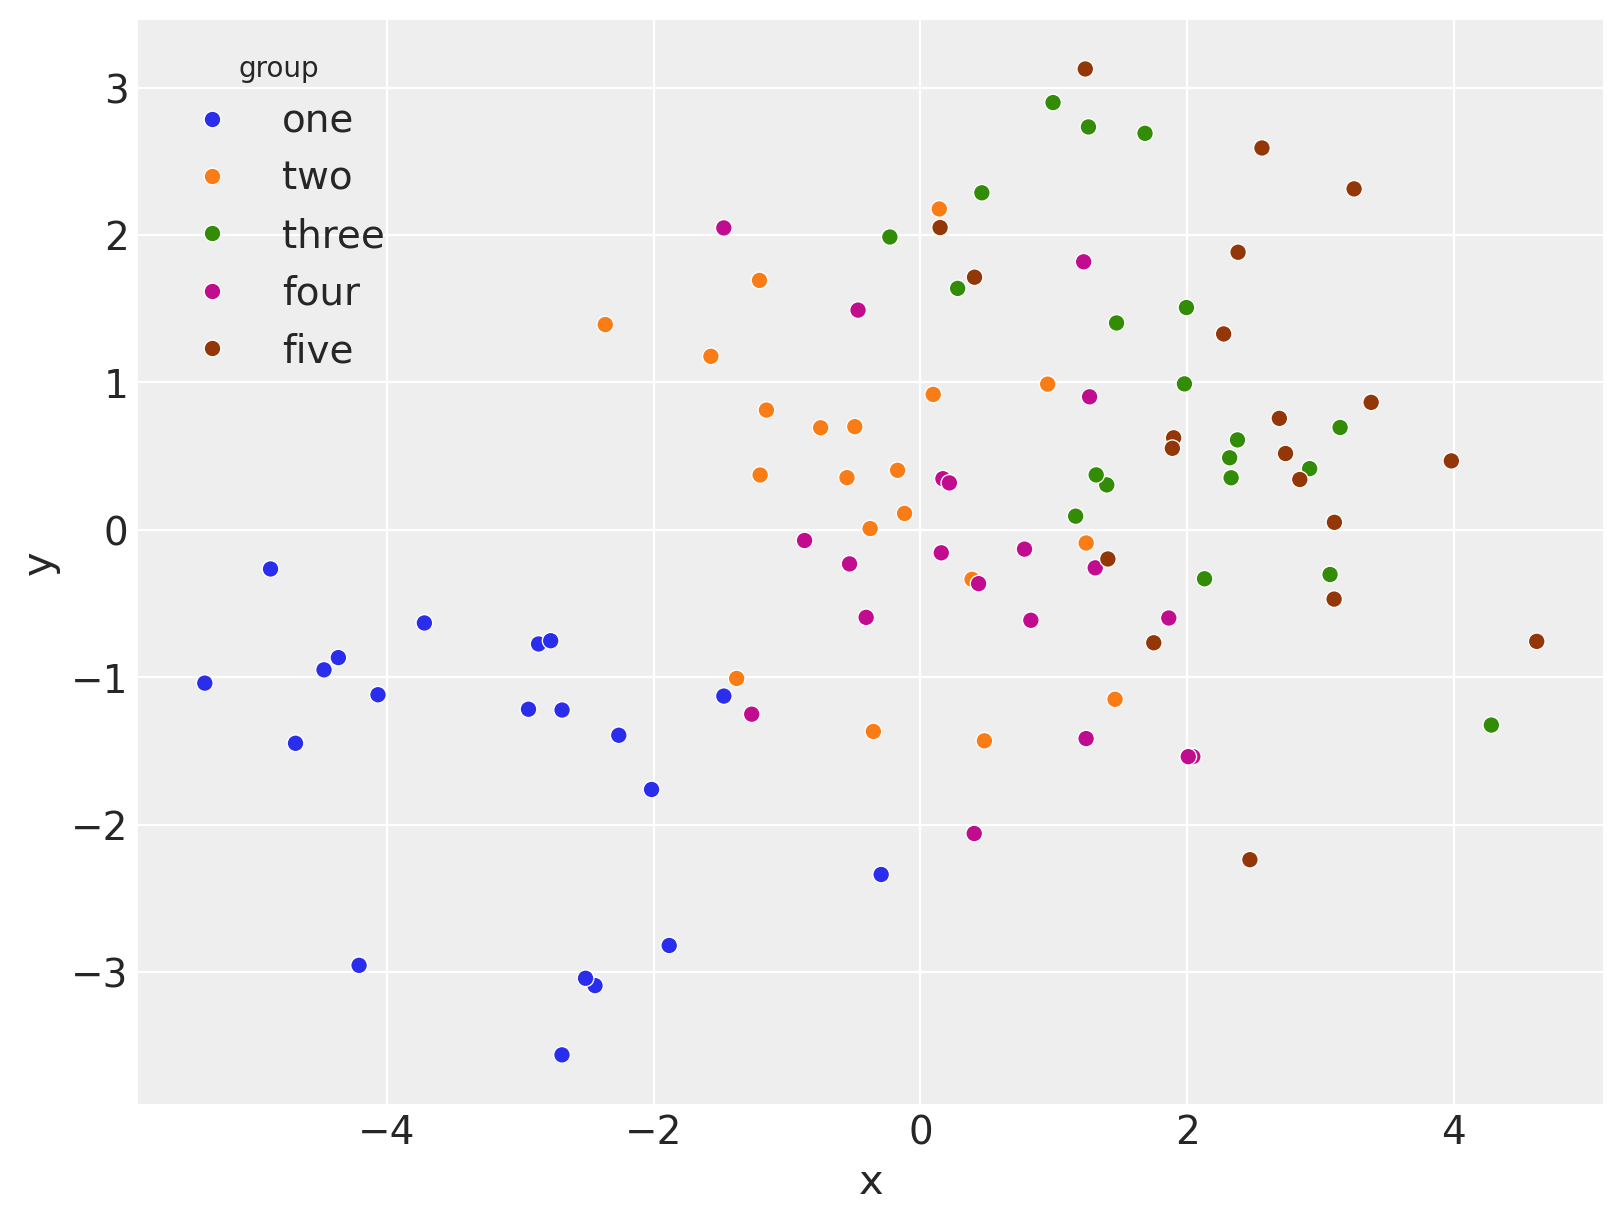

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=data, x="x", y="y", hue="group", ax=ax);

The rest of the notebook will cover different ways that we can analyse this data using linear models.

## Model 1: Pooled regression

First we examine the simplest model - plain linear regression which pools all the data and has no knowledge of the group/multi-level structure of the data.

From a causal perspective, this approach embodies the belief that $x$ causes $y$ and that this relationship is constant across all groups, or groups are simply not considered. This can be shown in the causal DAG below.

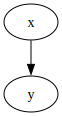

In [6]:
g = gr.Digraph()
g.node(name="x", label="x")
g.node(name="y", label="y")
g.edge(tail_name="x", head_name="y")
g

We could describe this model mathematically as:

$$
\begin{aligned}
\beta_0, \beta_1 &\sim \text{Normal}(0, 5) \\
\sigma &\sim \text{Gamma}(2, 2) \\
\mu_i &= \beta_0 + \beta_1 x_i \\
y_i &\sim \text{Normal}(\mu_i, \sigma)
\end{aligned}
$$

:::{note}
We can also express Model 1 in Wilkinson notation as `y ~ 1 + x` which is equivalent to `y ~ x` as the intercept is included by default.

* The `1` term corresponds to the intercept term $\beta_0$.
* The `x` term corresponds to the slope term $\beta_1$.
:::

So now we can express this as a PyMC model. We can notice how closely the model syntax mirrors the mathematical notation above.

In [7]:
with pm.Model() as model1:
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    sigma = pm.Gamma("sigma", 2, 2)
    x = pm.Data("x", data.x, dims="obs_id")
    μ = pm.Deterministic("μ", β0 + β1 * x, dims="obs_id")
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

And we can visualize the DAG which can be a useful way to check that our model is correctly specified.

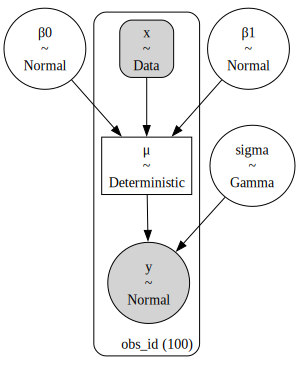

In [8]:
pm.model_to_graphviz(model1)

### Conduct inference

In [9]:
with model1:
    idata1 = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


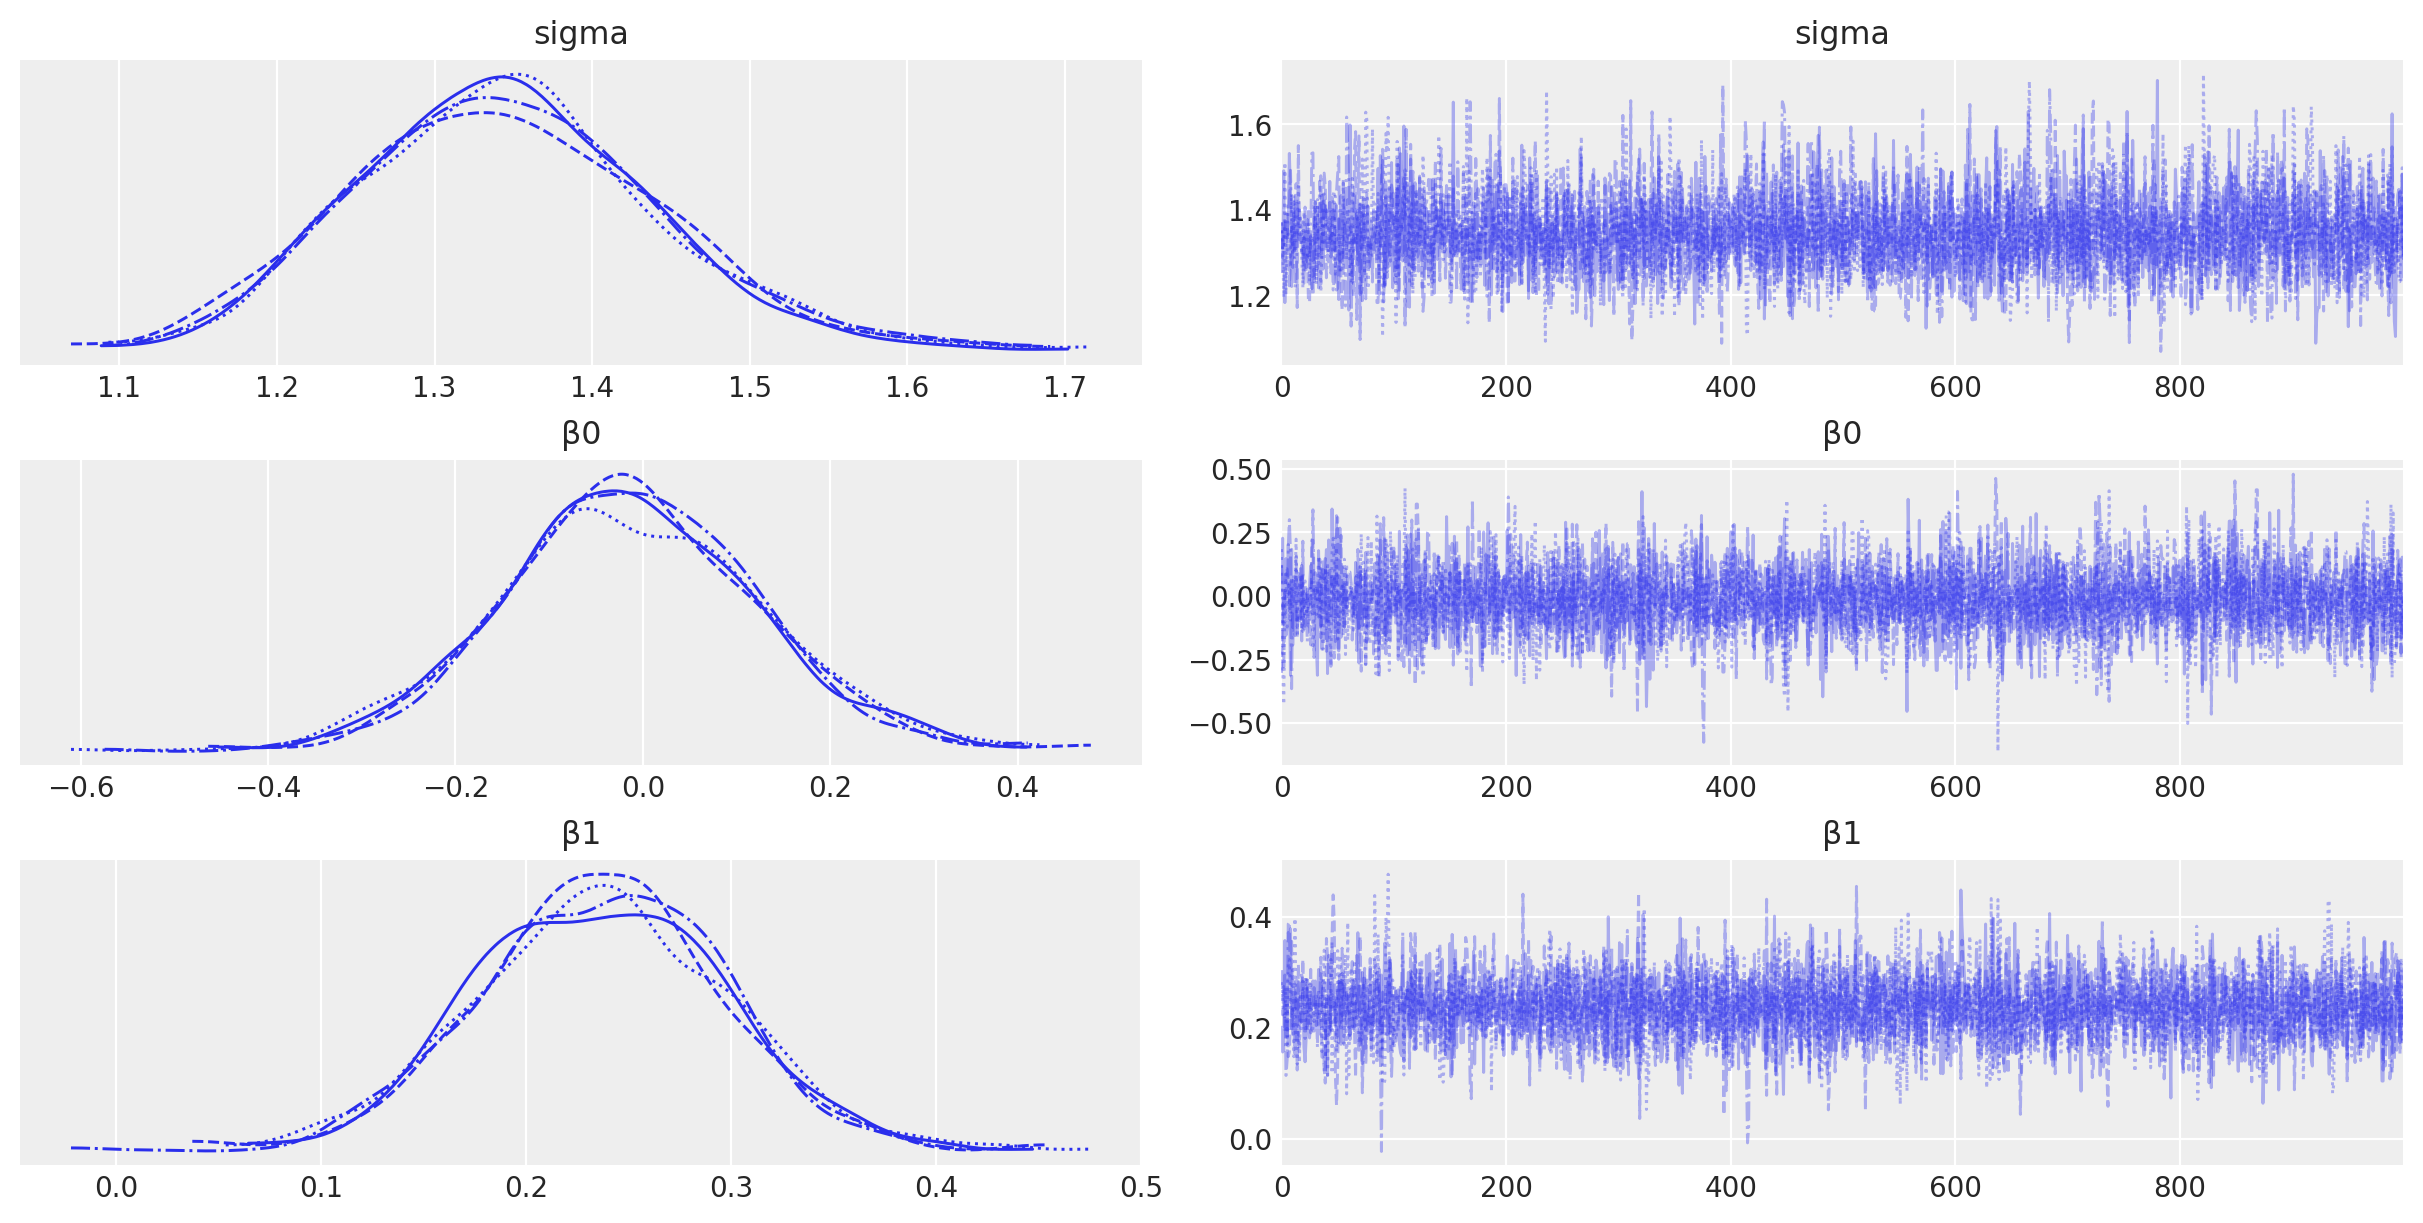

In [10]:
az.plot_trace(idata1, var_names=["~μ"]);

### Visualisation

First we'll define a handy predict function which will do out of sample predictions for us. This will be handy when it comes to visualising the model fits.

In [11]:
def predict(model: pm.Model, idata: az.InferenceData, predict_at: dict) -> az.InferenceData:
    """Do posterior predictive inference at a set of out of sample points specified by `predict_at`."""
    with model:
        pm.set_data(predict_at)
        idata.extend(pm.sample_posterior_predictive(idata, var_names=["y", "μ"], random_seed=rng))
    return idata

And now let's use that `predict` function to do out of sample predictions which we will use for visualisation.

In [12]:
xi = np.linspace(data.x.min(), data.x.max(), 20)

idata1 = predict(
    model=model1,
    idata=idata1,
    predict_at={"x": xi},
)

Sampling: [y]


Output()

Finally, we can now visualise the model fit to data, and our posterior in parameter space.

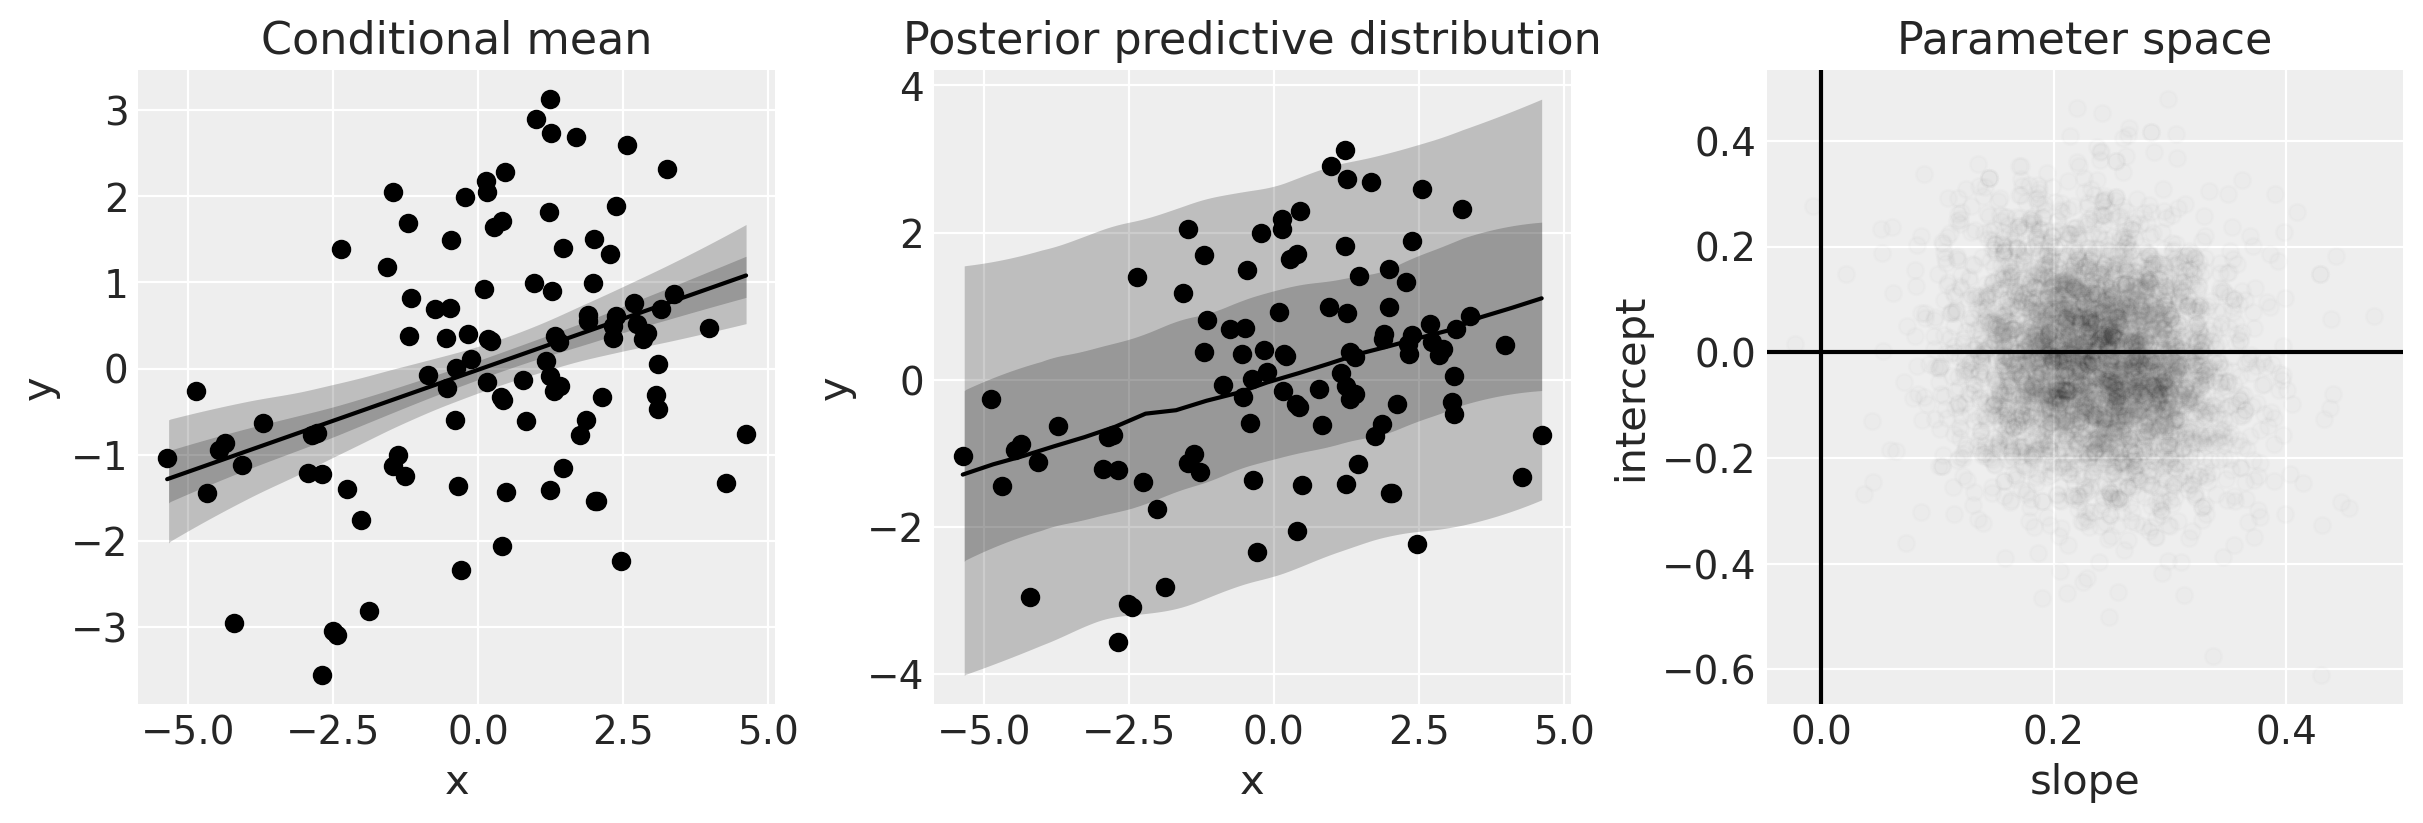

In [13]:
def plot_band(xi, var: xr.DataArray, ax, color: str):
    ax.plot(xi, var.mean(["chain", "draw"]), color=color)

    az.plot_hdi(
        xi,
        var,
        hdi_prob=0.6,
        color=color,
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax,
    )
    az.plot_hdi(
        xi,
        var,
        hdi_prob=0.95,
        color=color,
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax,
    )


def plot(idata: az.InferenceData):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # conditional mean plot ---------------------------------------------
    ax[0].scatter(data.x, data.y, color="k")
    plot_band(xi, idata.posterior_predictive.μ, ax=ax[0], color="k")
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

    # posterior prediction ----------------------------------------------
    ax[1].scatter(data.x, data.y, color="k")
    plot_band(xi, idata.posterior_predictive.y, ax=ax[1], color="k")
    ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")

    # parameter space ---------------------------------------------------
    ax[2].scatter(
        az.extract(idata, var_names=["β1"]),
        az.extract(idata, var_names=["β0"]),
        color="k",
        alpha=0.01,
        rasterized=True,
    )

    # formatting
    ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")
    ax[2].axhline(y=0, c="k")
    ax[2].axvline(x=0, c="k")


plot(idata1)

The plot on the left shows the data and the posterior of the **conditional mean**. For a given $x$, we get a posterior distribution of the model (i.e. of $\mu$).

The plot in the middle shows the conditional **posterior predictive distribution**, which gives a statement about the data we expect to see. Intuitively, this can be understood as not only incorporating what we know of the model (left plot) but also what we know about the distribution of error.

The plot on the right shows our posterior beliefs in **parameter space**.

One of the clear things about this analysis is that we have credible evidence that $x$ and $y$ are _positively_ correlated. We can see this from the posterior over the slope (see right hand panel in the figure above) which we isolate in the plot below.

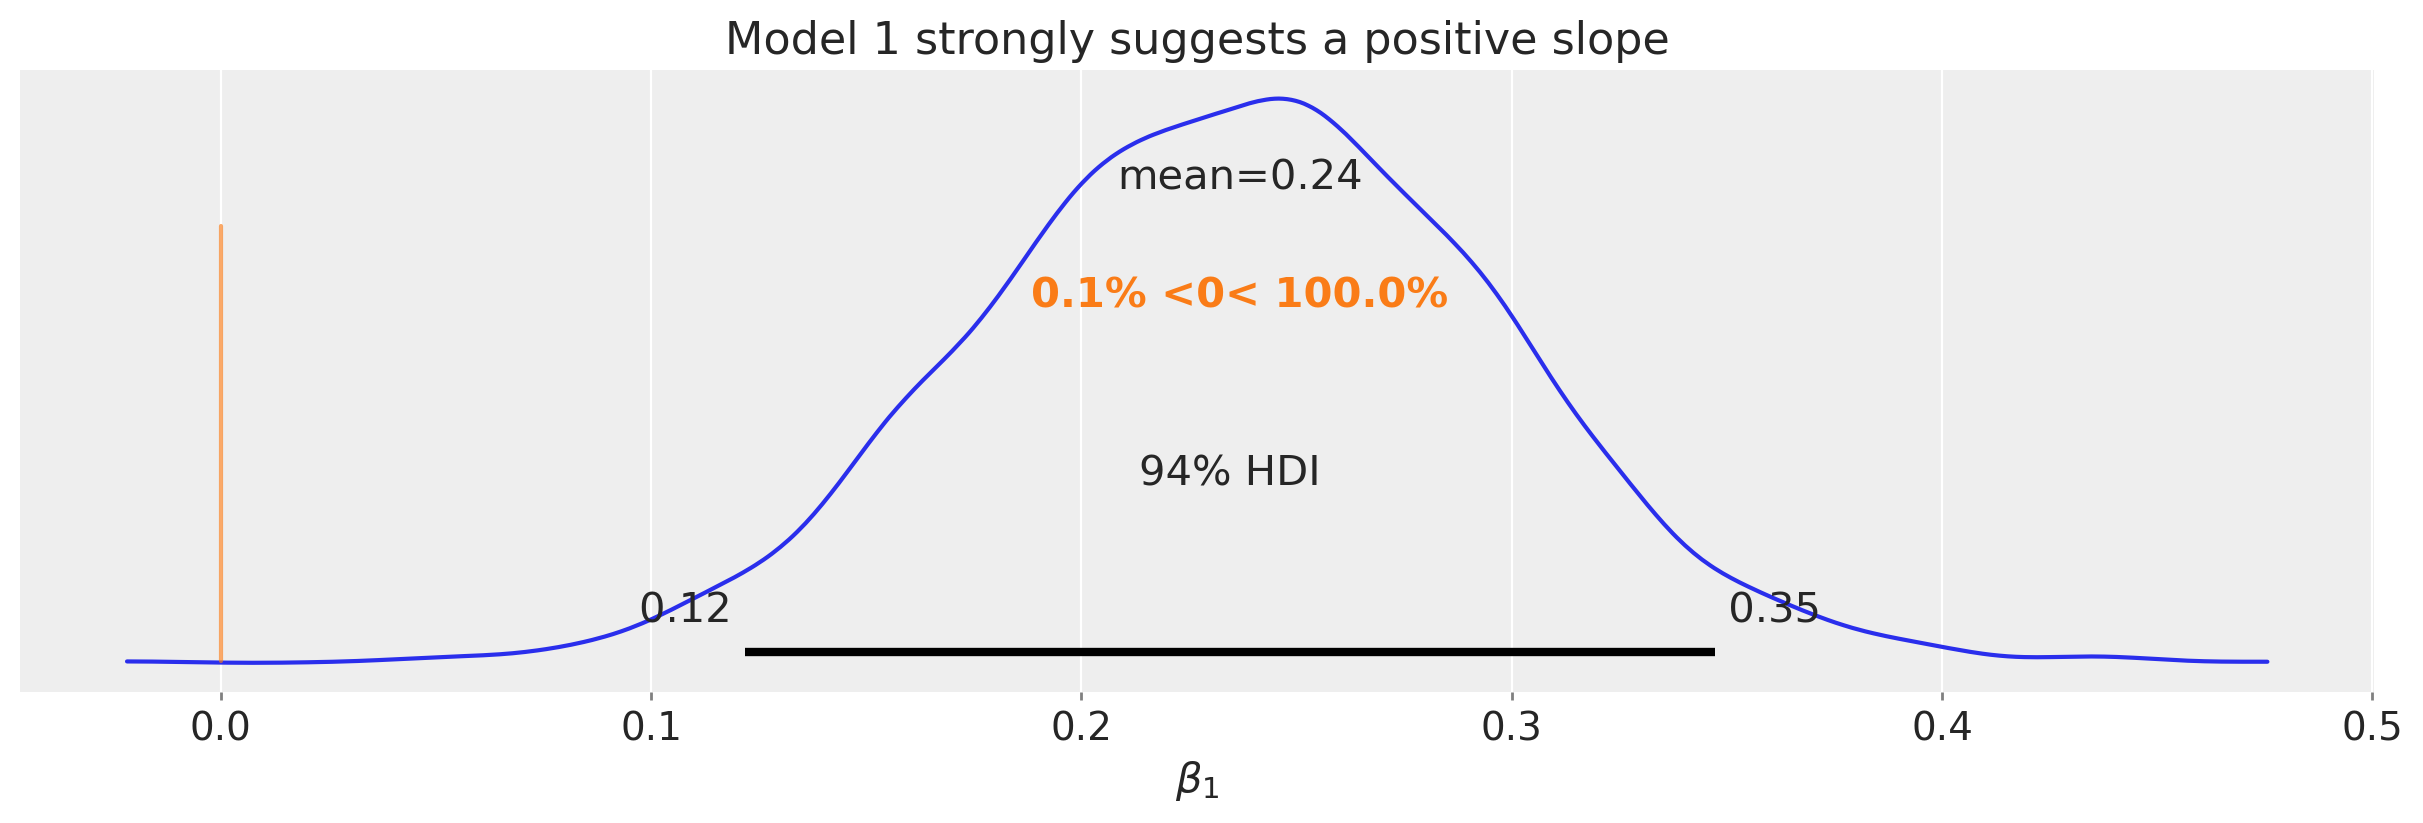

In [14]:
ax = az.plot_posterior(idata1.posterior["β1"], ref_val=0)
ax.set(title="Model 1 strongly suggests a positive slope", xlabel=r"$\beta_1$");

## Model 2: Unpooled regression with counfounder included

We will use the same data in this analysis, but this time we will use our knowledge that data come from groups. From a causal perspective we are exploring the notion that both $x$ and $y$ are influenced by group membership. This can be shown in the causal directed acyclic graph ([DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph)) below.


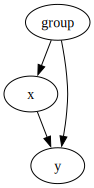

In [15]:
g = gr.Digraph()
g.node(name="x", label="x")
g.node(name="g", label="group")
g.node(name="y", label="y")
g.edge(tail_name="x", head_name="y")
g.edge(tail_name="g", head_name="x")
g.edge(tail_name="g", head_name="y")
g

So we can see that $group$ is a [confounding variable](https://en.wikipedia.org/wiki/Confounding). So if we are trying to discover the causal relationship of $x$ on $y$, we need to account for the confounding variable $group$. Model 1 did not do this and so arrived at the wrong conclusion. But Model 2 will account for this.

More specifically we will essentially fit independent regressions to data within each group. This could also be described as an unpooled model. We could describe this model mathematically as:

$$
\begin{aligned}
\vec{\beta_0}, \vec{\beta_1} &\sim \text{Normal}(0, 5) \\
\sigma &\sim \text{Gamma}(2, 2) \\
\mu_i &= \vec{\beta_0}[g_i] + \vec{\beta_1}[g_i] x_i \\
y_i &\sim \text{Normal}(\mu_i, g_i)
\end{aligned}
$$

Where $g_i$ is the group index for observation $i$. So the parameters $\vec{\beta_0}$ and $\vec{\beta_1}$ are now length $G$ vectors, not scalars. And the $[g_i]$ acts as an index to look up the group for the $i^\text{th}$ observation.

:::{note}
We can also express this Model 2 in Wilkinson notation as `y ~ 0 + g + x:g`.

* The `g` term captures the group specific intercept $\beta_0[g_i]$ parameters.
* The `0` means we do not have a global intercept term, leaving the group specific intercepts to be the only intercepts.
* The `x:g` term captures group specific slope $\beta_1[g_i]$ parameters.
:::

Let's express Model 2 with PyMC code.

In [16]:
coords = {"group": group_list}

with pm.Model(coords=coords) as model2:
    # Define priors
    β0 = pm.Normal("β0", 0, sigma=5, dims="group")
    β1 = pm.Normal("β1", 0, sigma=5, dims="group")
    sigma = pm.Gamma("sigma", 2, 2)
    # Data
    x = pm.Data("x", data.x, dims="obs_id")
    g = pm.Data("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

By plotting the DAG for this model it is clear to see that we now have individual intercept and slope parameters for each of the groups.

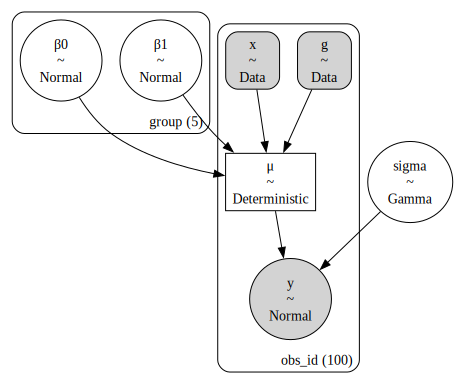

In [17]:
pm.model_to_graphviz(model2)

### Conduct inference

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


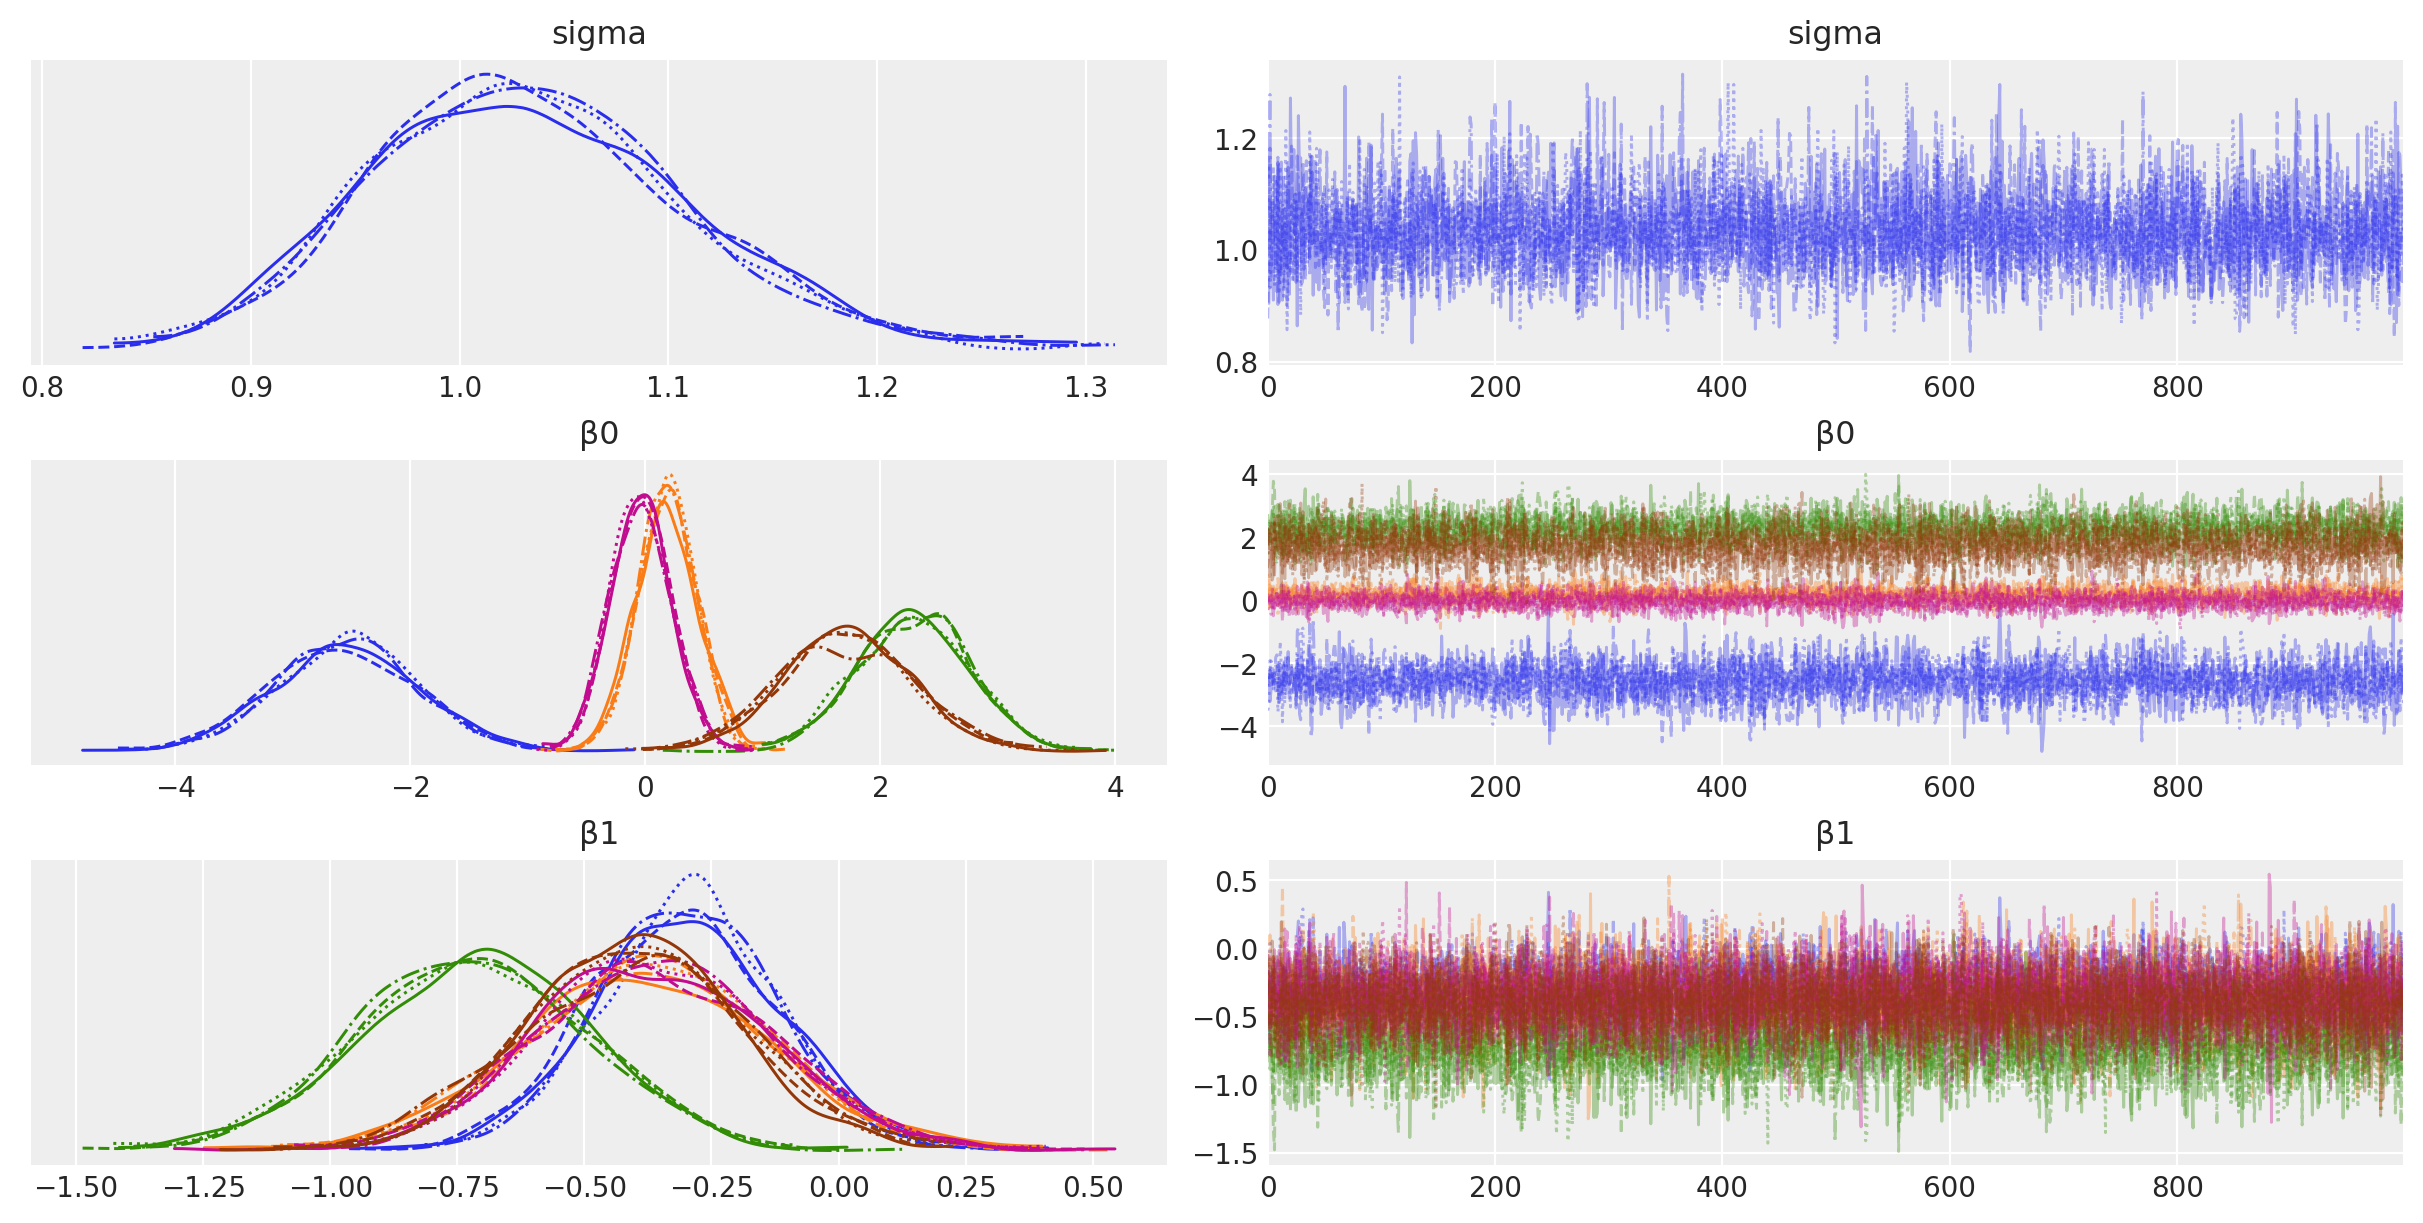

In [18]:
with model2:
    idata2 = pm.sample(random_seed=rng)

az.plot_trace(idata2, var_names=["~μ"]);

### Visualisation

In [19]:
# Generate values of xi and g for posterior prediction
n_points = 10
n_groups = len(data.group.unique())
# Generate xi values for each group and concatenate them
xi = np.concatenate(
    [
        np.linspace(group[1].x.min(), group[1].x.max(), n_points)
        for group in data.groupby("group_idx")
    ]
)
# Generate the group indices array g and cast it to integers
g = np.concatenate([[i] * n_points for i in range(n_groups)]).astype(int)
predict_at = {"x": xi, "g": g}

In [20]:
idata2 = predict(
    model=model2,
    idata=idata2,
    predict_at=predict_at,
)

Sampling: [y]


Output()

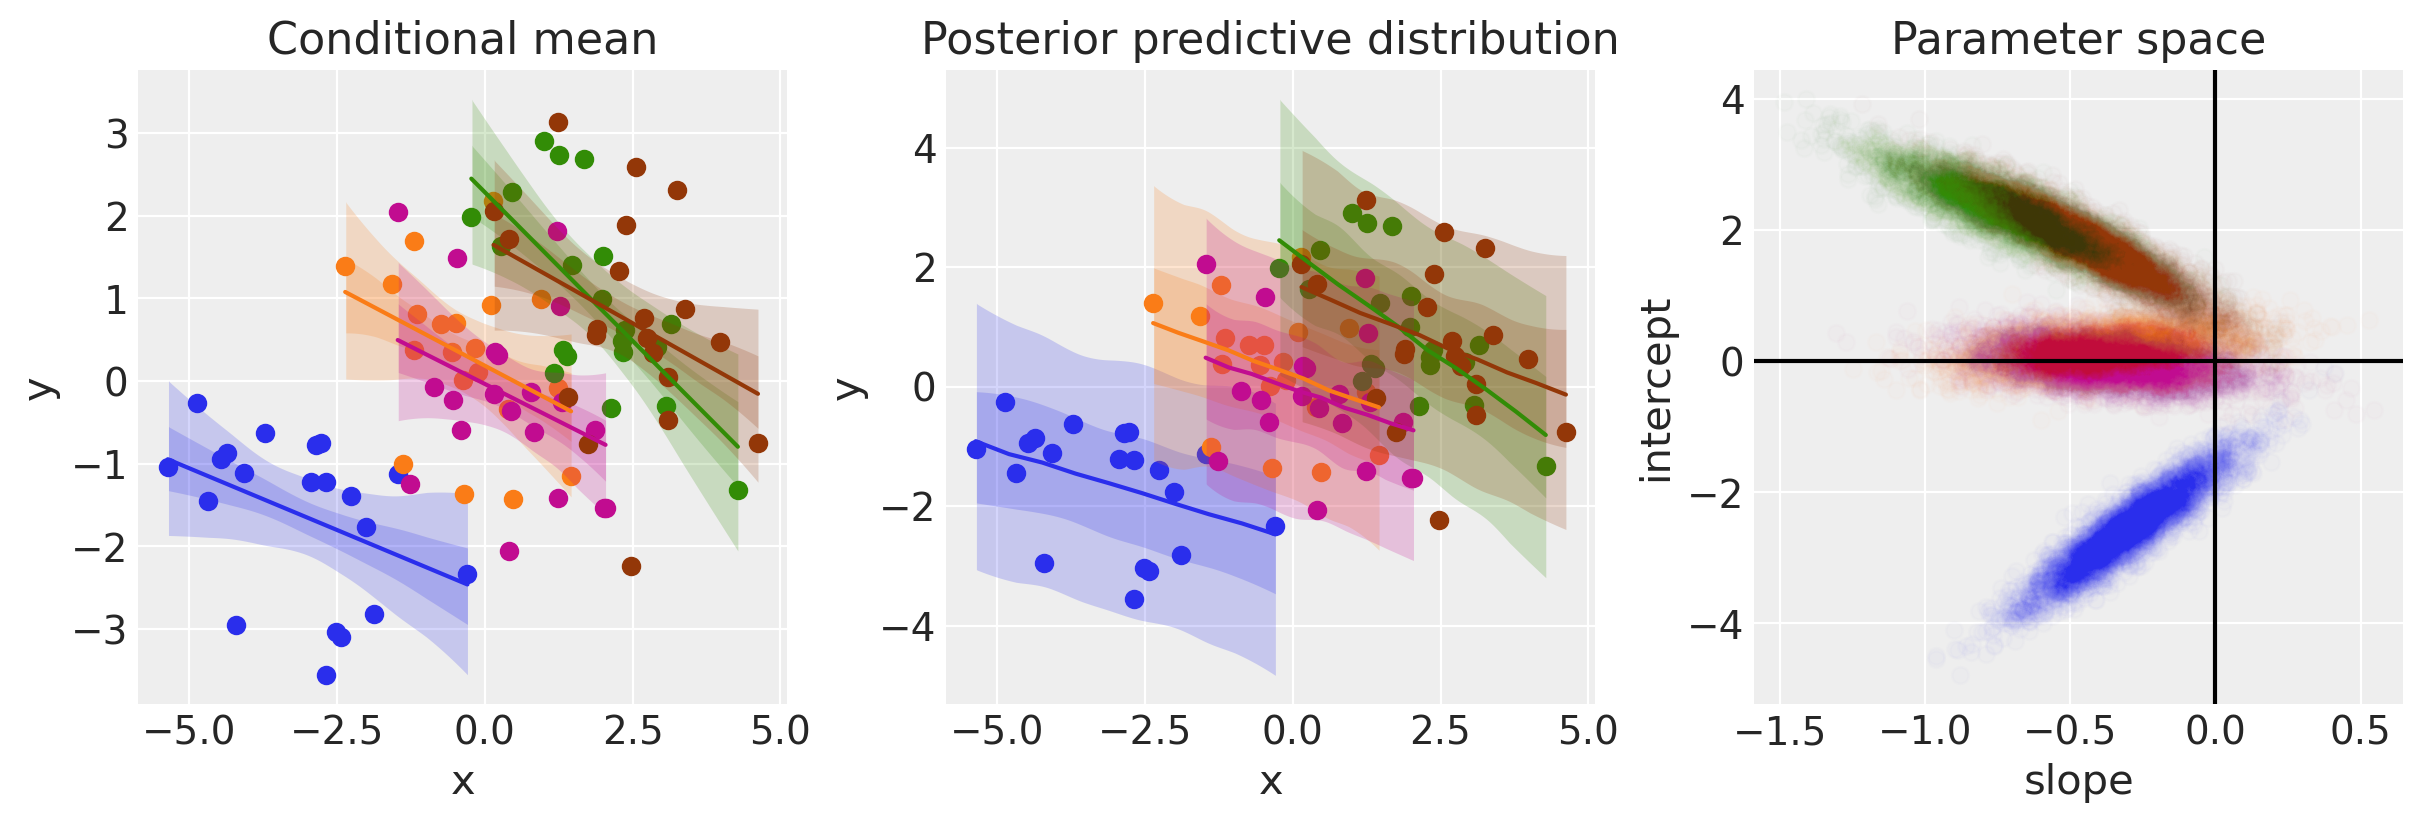

In [21]:
def plot(idata):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(len(group_list)):
        # conditional mean plot ---------------------------------------------
        ax[0].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
        plot_band(
            xi[g == i],
            idata.posterior_predictive.μ.isel(obs_id=(g == i)),
            ax=ax[0],
            color=f"C{i}",
        )

        # posterior prediction ----------------------------------------------
        ax[1].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
        plot_band(
            xi[g == i],
            idata.posterior_predictive.y.isel(obs_id=(g == i)),
            ax=ax[1],
            color=f"C{i}",
        )

    # formatting
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")
    ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")

    # parameter space ---------------------------------------------------
    for i, _ in enumerate(group_list):
        ax[2].scatter(
            az.extract(idata, var_names="β1")[i, :],
            az.extract(idata, var_names="β0")[i, :],
            color=f"C{i}",
            alpha=0.01,
            rasterized=True,
            zorder=2,
        )

    ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")
    ax[2].axhline(y=0, c="k")
    ax[2].axvline(x=0, c="k")
    return ax


plot(idata2);

In contrast to Model 1, when we consider groups we can see that now the evidence points toward _negative_ relationships between $x$ and $y$. We can see that from the negative slopes in the left and middle panels of the plot above, as well as from the majority of the posterior samples for the slope parameter being negative in the left panel above.

The plot below takes a closer look at the group level slope parameters.

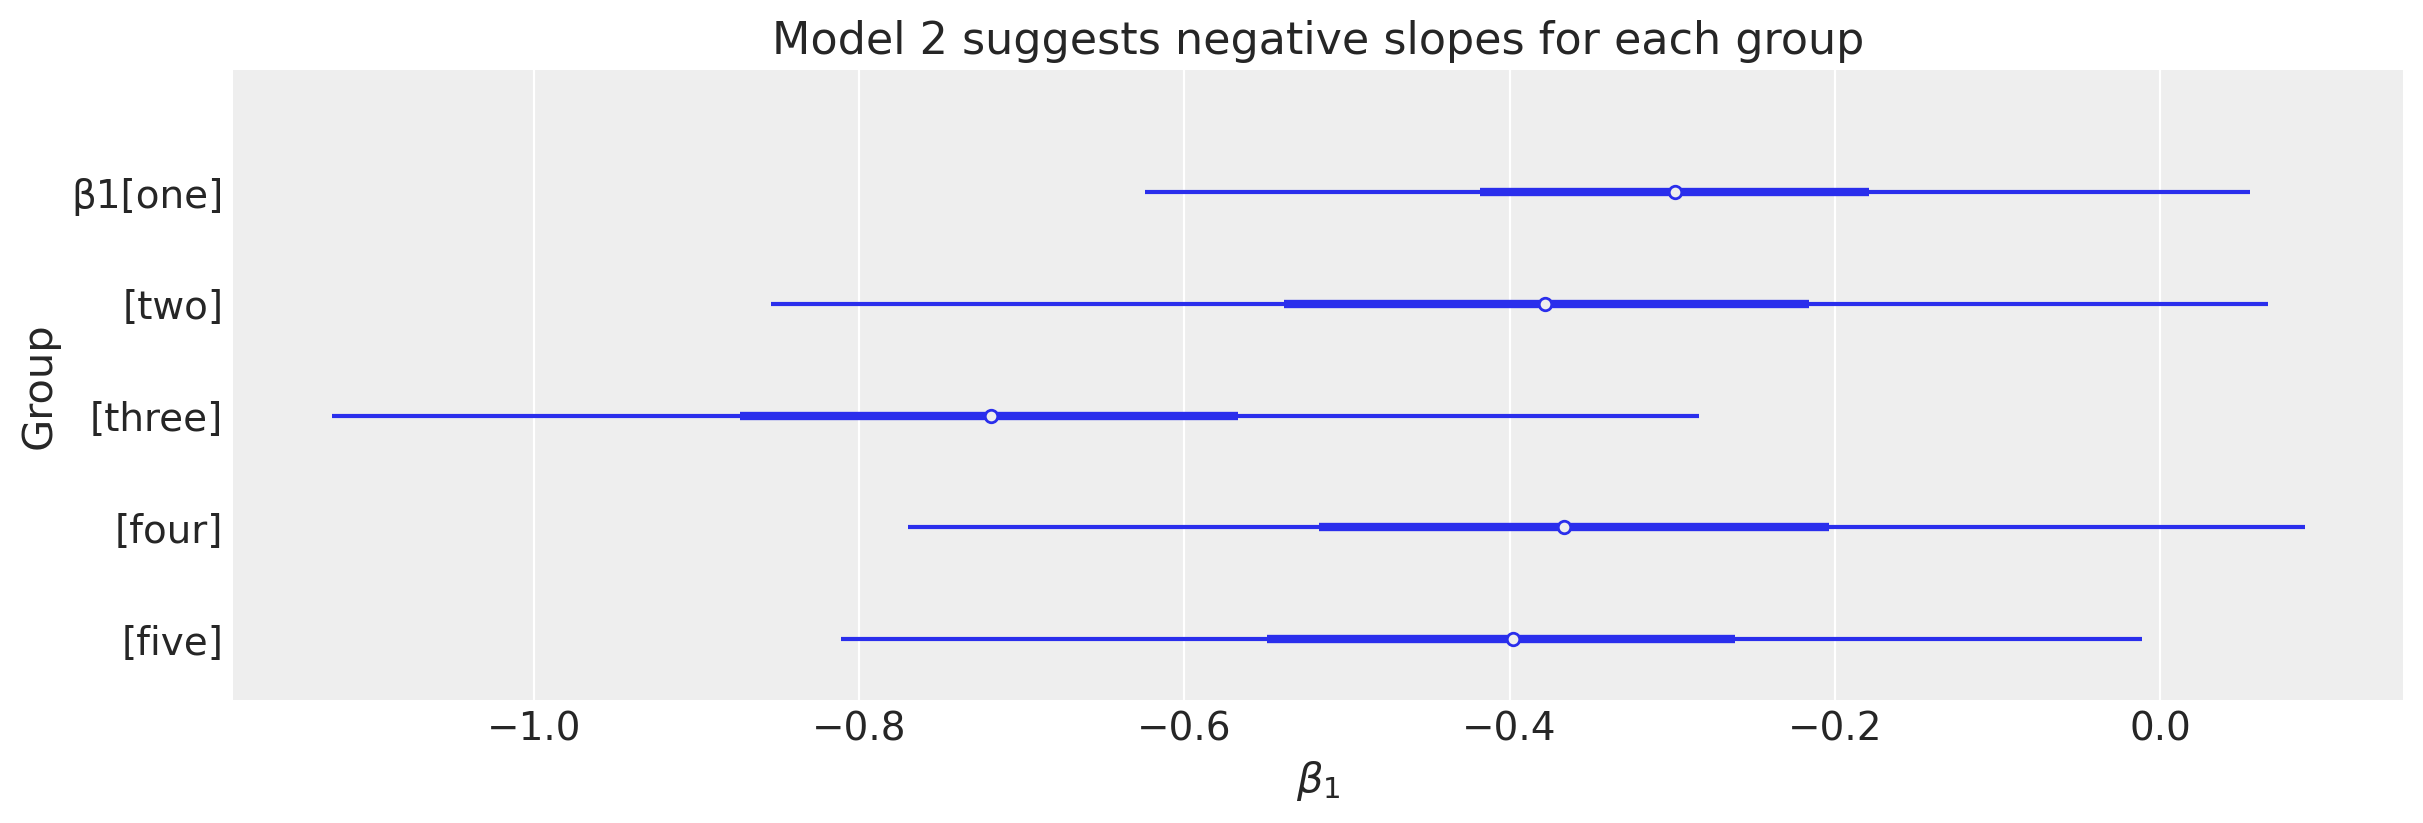

In [22]:
ax = az.plot_forest(idata2.posterior["β1"], combined=True, figsize=figsize)
ax[0].set(
    title="Model 2 suggests negative slopes for each group", xlabel=r"$\beta_1$", ylabel="Group"
);

## Model 3: Partial pooling model with confounder included

Model 3 assumes the same causal DAG as model 2 (see above). However, we can go further and incorporate more knowledge about the structure of our data. Rather than treating each group as entirely independent, we can use our knowledge that these groups are drawn from a population-level distribution. We could formalise this as saying that the group-level slopes and intercepts are modeled as deflections from a population-level slope and intercept, respectively.

And we could describe this model mathematically as:

$$
\begin{aligned}
\beta_0 &\sim \text{Normal}(0, 5) \\
\beta_1 &\sim \text{Normal}(0, 5) \\
p_{0\sigma}, p_{1\sigma} &\sim \text{Gamma}(2, 2) \\
\vec{u_0} &\sim \text{Normal}(0, p_{0\sigma}) \\ 
\vec{u_1} &\sim \text{Normal}(0, p_{1\sigma}) \\ 
\sigma &\sim \text{Gamma}(2, 2) \\
\mu_i &= \overbrace{
            \left( 
                \underbrace{\beta_0}_{\text{pop}} 
                + \underbrace{\vec{u_0}[g_i]}_{\text{group}} 
            \right)
         }^{\text{intercept}}
      + \overbrace{
            \left( 
                \underbrace{\beta_1 \cdot x_i}_{\text{pop}} 
                + \underbrace{\vec{u_1}[g_i] \cdot x_i}_{\text{group}} 
            \right)
         }^{\text{slope}} \\
y_i &\sim \text{Normal}(\mu_i, \sigma)
\end{aligned}
$$

where 
* $\beta_0$ and $\beta_1$ are the population level intercepts and slopes, respectively.
* $\vec{u_0}$ and $\vec{u_1}$ are group level deflections from the population level parameters.
* $p_{0\sigma}, p_{1\sigma}$ are the standard deviations of the intercept and slope deflections and can be thought of as 'shrinkage parameters'. 
  * In the limt of $p_{0\sigma}, p_{1\sigma} \rightarrow \infty$ we recover the unpooled model.
  * In the limit of $p_{0\sigma}, p_{1\sigma} \rightarrow 0$ we recover the pooled model.

:::{note}
We can also express this Model 3 in Wilkinson notation as `1 + x + (1 + x | g)`.

* The `1` captures the global intercept, $\beta_0$.
* The `x` captures the global slope, $\beta_1$.
* The `(1 + x | g)` term captures group specific terms for the intercept and slope.
  * `1 | g` captures the group specific intercept deflections $\vec{u_0}$ parameters.
  * `x | g` captures the group specific slope deflections $\vec{u_1}[g_i]$ parameters.
:::

In [23]:
with pm.Model(coords=coords) as model3:
    # Population level priors
    β0 = pm.Normal("β0", 0, 5)
    β1 = pm.Normal("β1", 0, 5)
    # Group level shrinkage
    intercept_sigma = pm.Gamma("intercept_sigma", 2, 2)
    slope_sigma = pm.Gamma("slope_sigma", 2, 2)
    # Group level deflections
    u0 = pm.Normal("u0", 0, intercept_sigma, dims="group")
    u1 = pm.Normal("u1", 0, slope_sigma, dims="group")
    # observations noise prior
    sigma = pm.Gamma("sigma", 2, 2)
    # Data
    x = pm.Data("x", data.x, dims="obs_id")
    g = pm.Data("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", (β0 + u0[g]) + (β1 * x + u1[g] * x), dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

The DAG of this model highlights the scalar population level parameters $\beta_0$ and $\beta_1$ and the group level parameters $\vec{u_0}$ and $\vec{u_1}$.

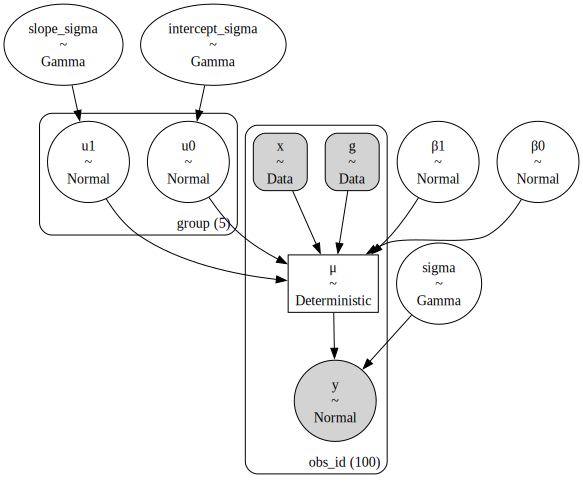

In [24]:
pm.model_to_graphviz(model3)

:::{note}

For the sake of completeness, there is another equivalent way to write this model.

$$
\begin{aligned}
p_{0\mu}, p_{1\mu} &\sim \text{Normal}(0, 5) \\
p_{0\sigma}, p_{1\sigma} &\sim \text{Gamma}(2, 2) \\
\vec{\beta_0} &\sim \text{Normal}(p_{0\mu}, p_{0\sigma}) \\
\vec{\beta_1} &\sim \text{Normal}(p_{1\mu}, p_{1\sigma}) \\
\sigma &\sim \text{Gamma}(2, 2) \\
\mu_i &= \vec{\beta_0}[g_i] +  \vec{\beta_1}[g_i] \cdot x_i \\
y_i &\sim \text{Normal}(\mu_i, \sigma)
\end{aligned}
$$

where $\vec{\beta_0}$ and $\vec{\beta_1}$ are the group-level parameters. These group level parameters can be thought of as being sampled from population level intercept distribution $\text{Normal}(p_{0\mu}, p_{0\sigma})$ and population level slope distribution $\text{Normal}(p_{1\mu}, p_{1\sigma})$. So these distributions would represent what we might expect to observe for some as yet unobserved group.

However, this formulation of the model does not so neatly map on to the Wilkinson notation. For this reason, we have chosen to present the model in the form given above. For an interesting discussion on this topic, see [Discussion #808](https://github.com/bambinos/bambi/discussions/808) in the [`bambi`](https://github.com/bambinos/bambi) repository.
:::

:::{seealso}
The hierarchical model we are considering contains a simplification in that the population level slope and intercept are assumed to be independent. It is possible to relax this assumption and model any correlation between these parameters by using a multivariate normal distribution. See the {ref}`lkj_prior_for_multivariate_normal` notebook for more details.
:::

:::{seealso}
In one sense this move from Model 2 to Model 3 can be seen as adding parameters, and therefore increasing model complexity. However, in another sense, adding this knowledge about the nested structure of the data actually provides a constraint over parameter space. It would be possible to engage in model comparison to arbitrate between these models - see for example the {ref}`GLM-model-selection` notebook for more details.
:::

### Conduct inference

In [25]:
with model3:
    idata3 = pm.sample(target_accept=0.95, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, intercept_sigma, slope_sigma, u0, u1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


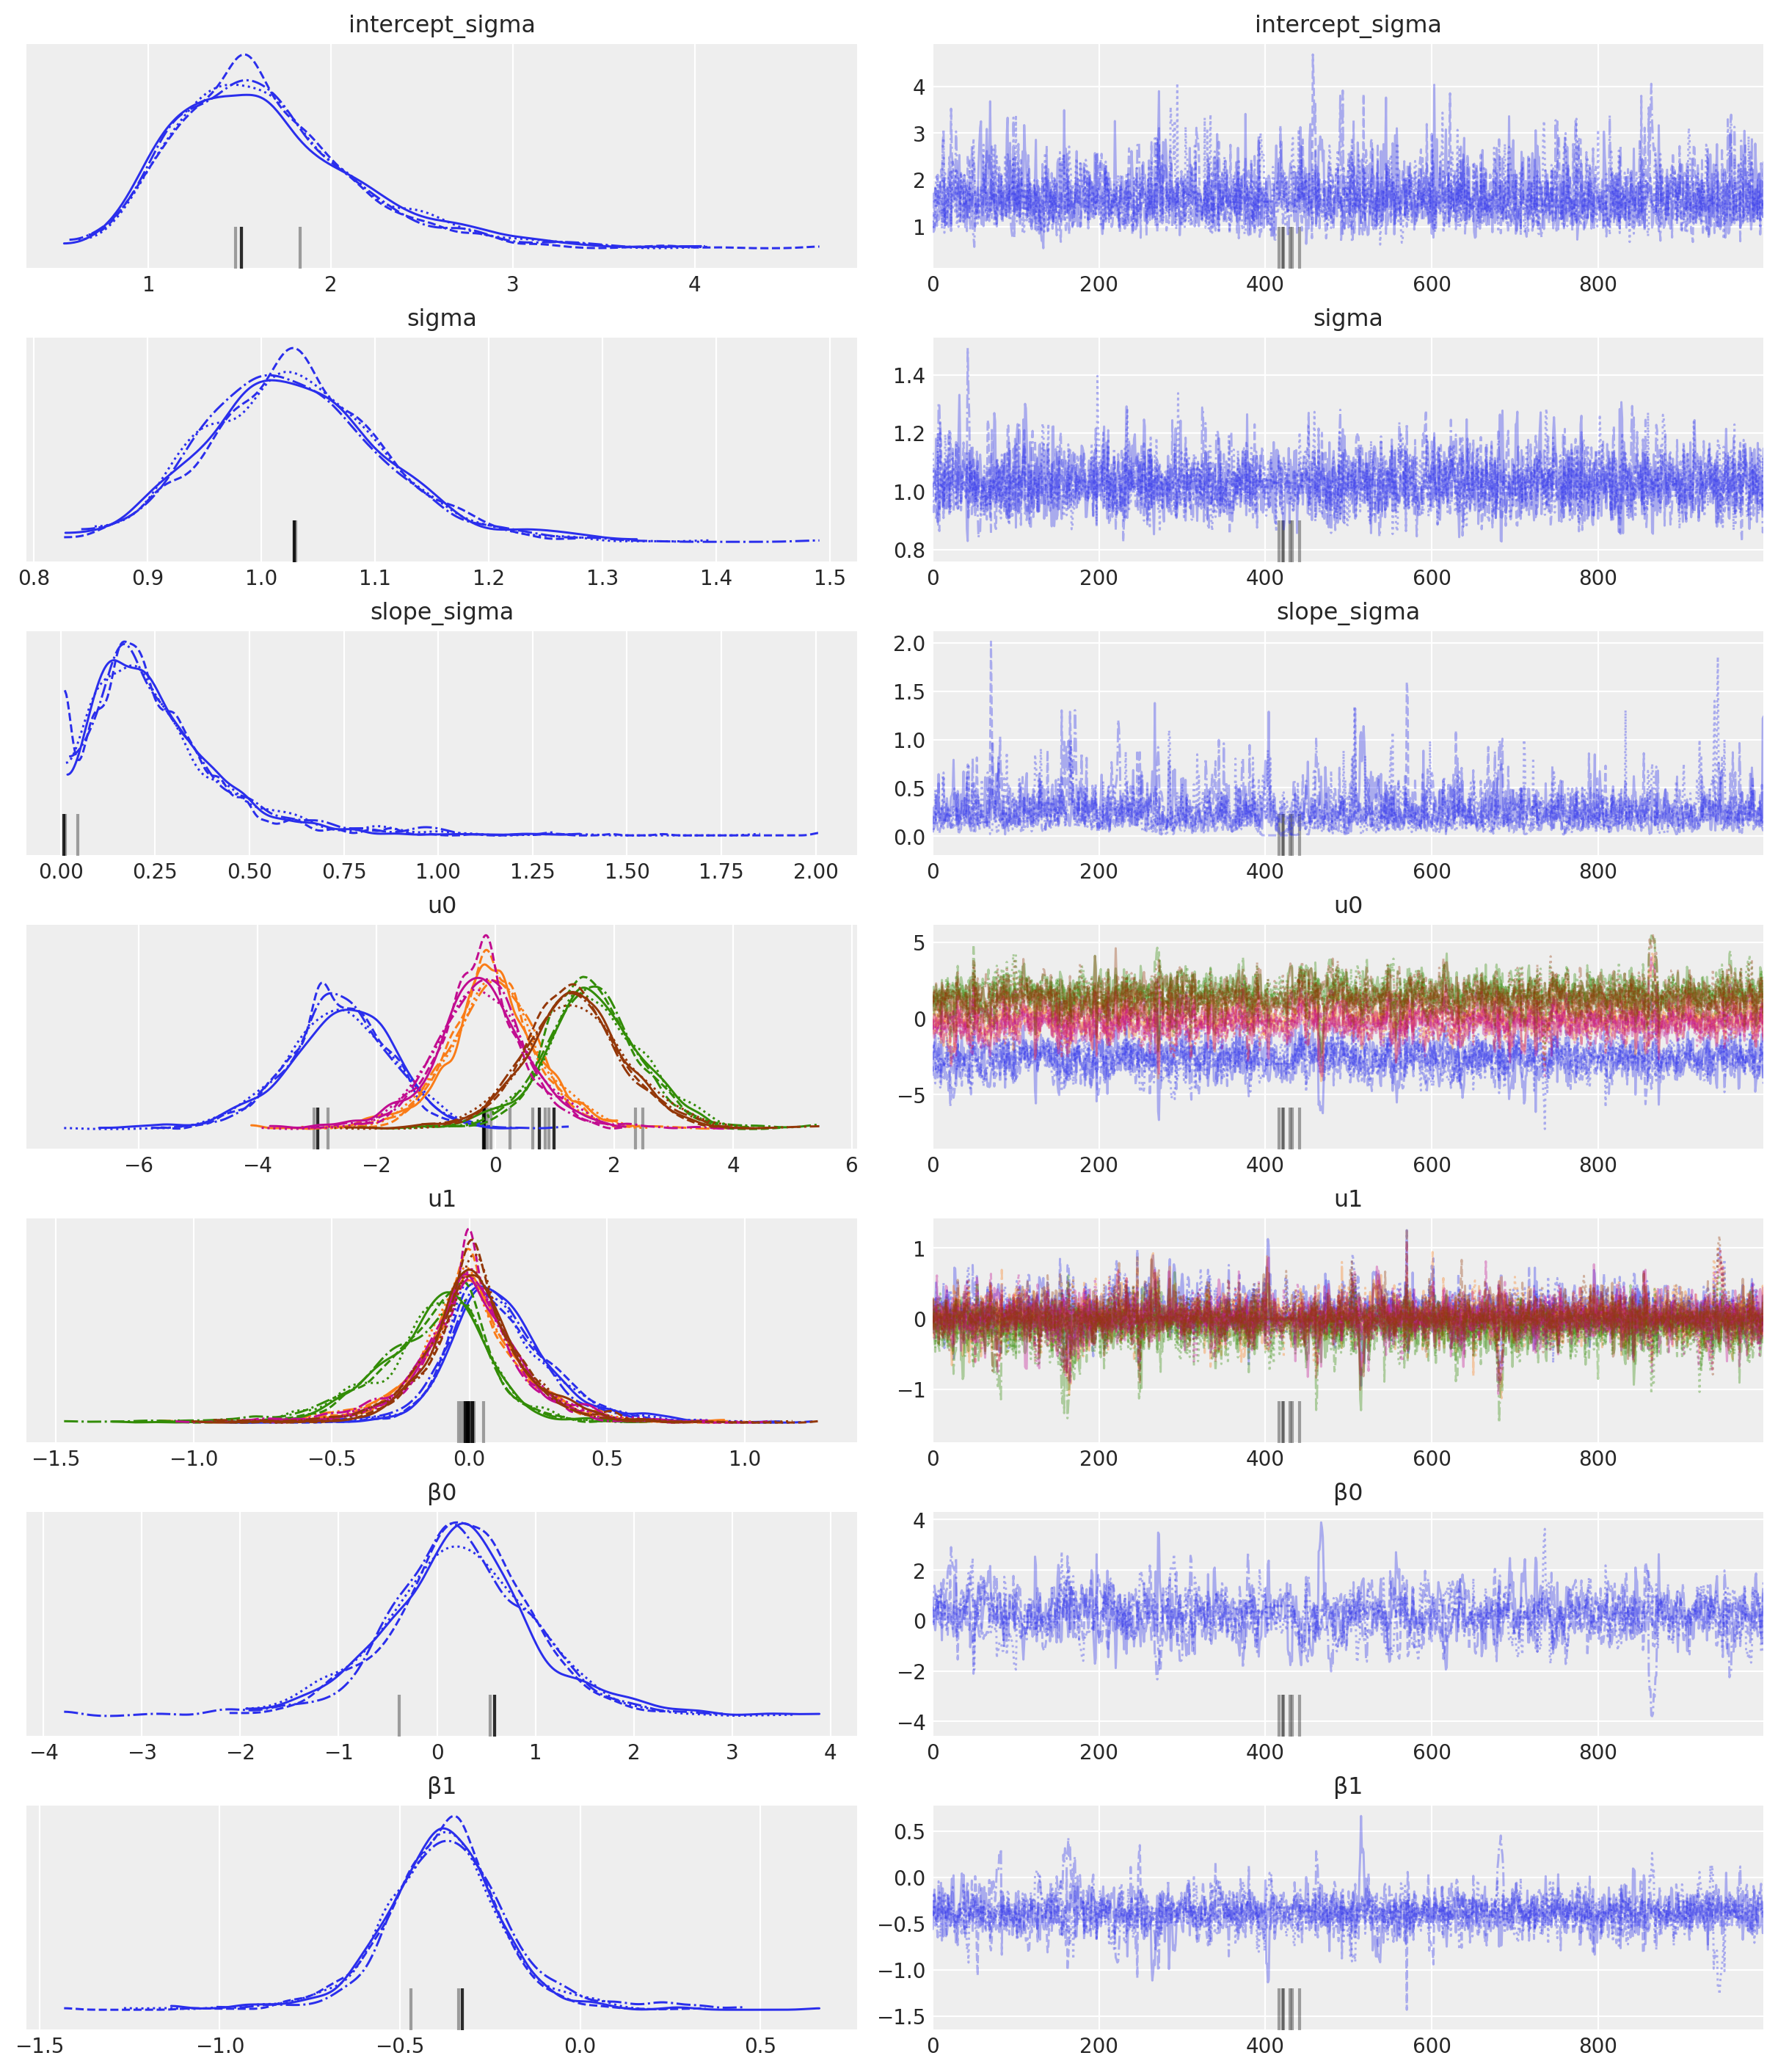

In [26]:
az.plot_trace(idata3, var_names=["~μ"]);

### Visualise

In [27]:
# Generate values of xi and g for posterior prediction
n_points = 10
n_groups = len(data.group.unique())
# Generate xi values for each group and concatenate them
xi = np.concatenate(
    [
        np.linspace(group[1].x.min(), group[1].x.max(), n_points)
        for group in data.groupby("group_idx")
    ]
)
# Generate the group indices array g and cast it to integers
g = np.concatenate([[i] * n_points for i in range(n_groups)]).astype(int)
predict_at = {"x": xi, "g": g}

idata3 = predict(
    model=model3,
    idata=idata3,
    predict_at=predict_at,
)

Sampling: [y]


Output()

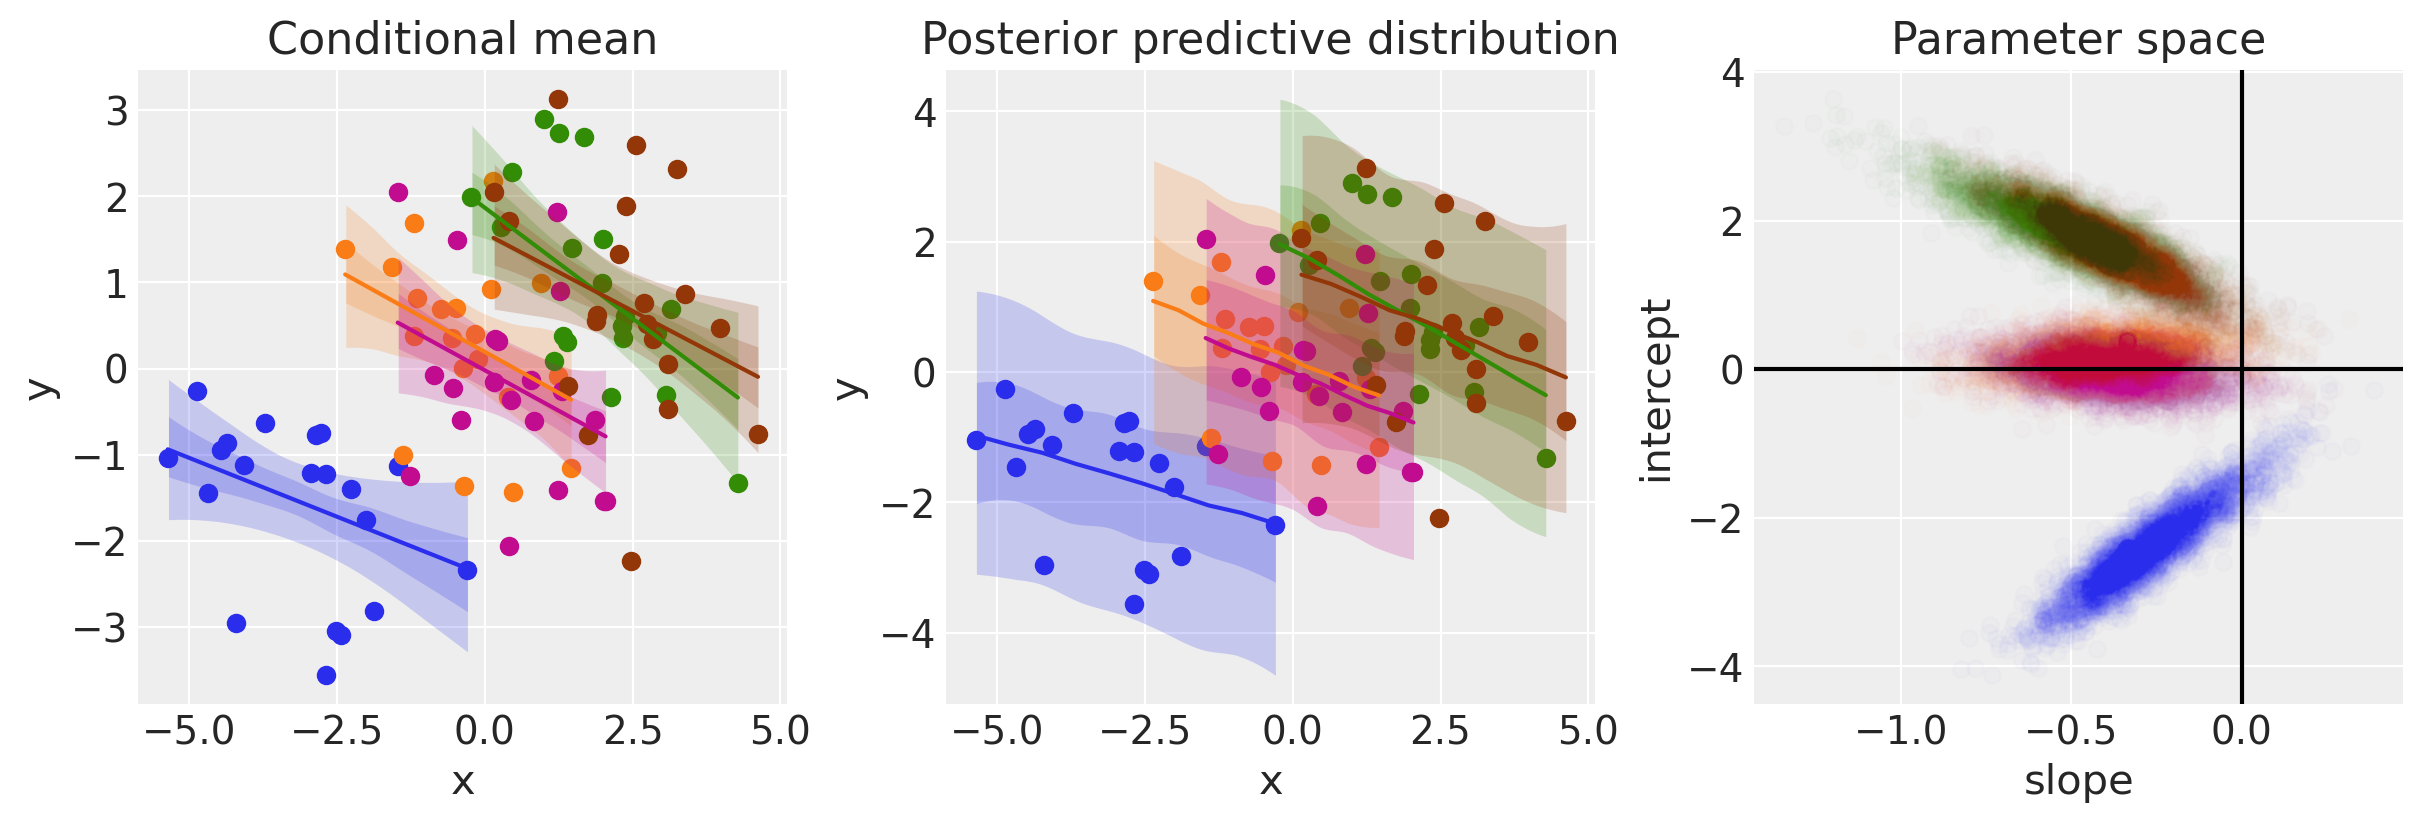

In [28]:
def plot(idata):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(len(group_list)):
        # conditional mean plot ---------------------------------------------
        ax[0].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
        plot_band(
            xi[g == i],
            idata.posterior_predictive.μ.isel(obs_id=(g == i)),
            ax=ax[0],
            color=f"C{i}",
        )

        # posterior prediction ----------------------------------------------
        ax[1].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
        plot_band(
            xi[g == i],
            idata.posterior_predictive.y.isel(obs_id=(g == i)),
            ax=ax[1],
            color=f"C{i}",
        )

    # formatting
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")
    ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")

    # parameter space ---------------------------------------------------
    for i, _ in enumerate(group_list):
        ax[2].scatter(
            az.extract(idata, var_names="β1") + az.extract(idata, var_names="u1")[i, :],
            az.extract(idata, var_names="β0") + az.extract(idata, var_names="u0")[i, :],
            color=f"C{i}",
            alpha=0.01,
            rasterized=True,
            zorder=2,
        )

    ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")
    ax[2].axhline(y=0, c="k")
    ax[2].axvline(x=0, c="k")
    return ax


ax = plot(idata3)

The panel on the right shows the group level posterior of the slope and intercept parameters as a contour plot. We can also just plot the marginal distribution below to see how much belief we have in the slope being less than zero.

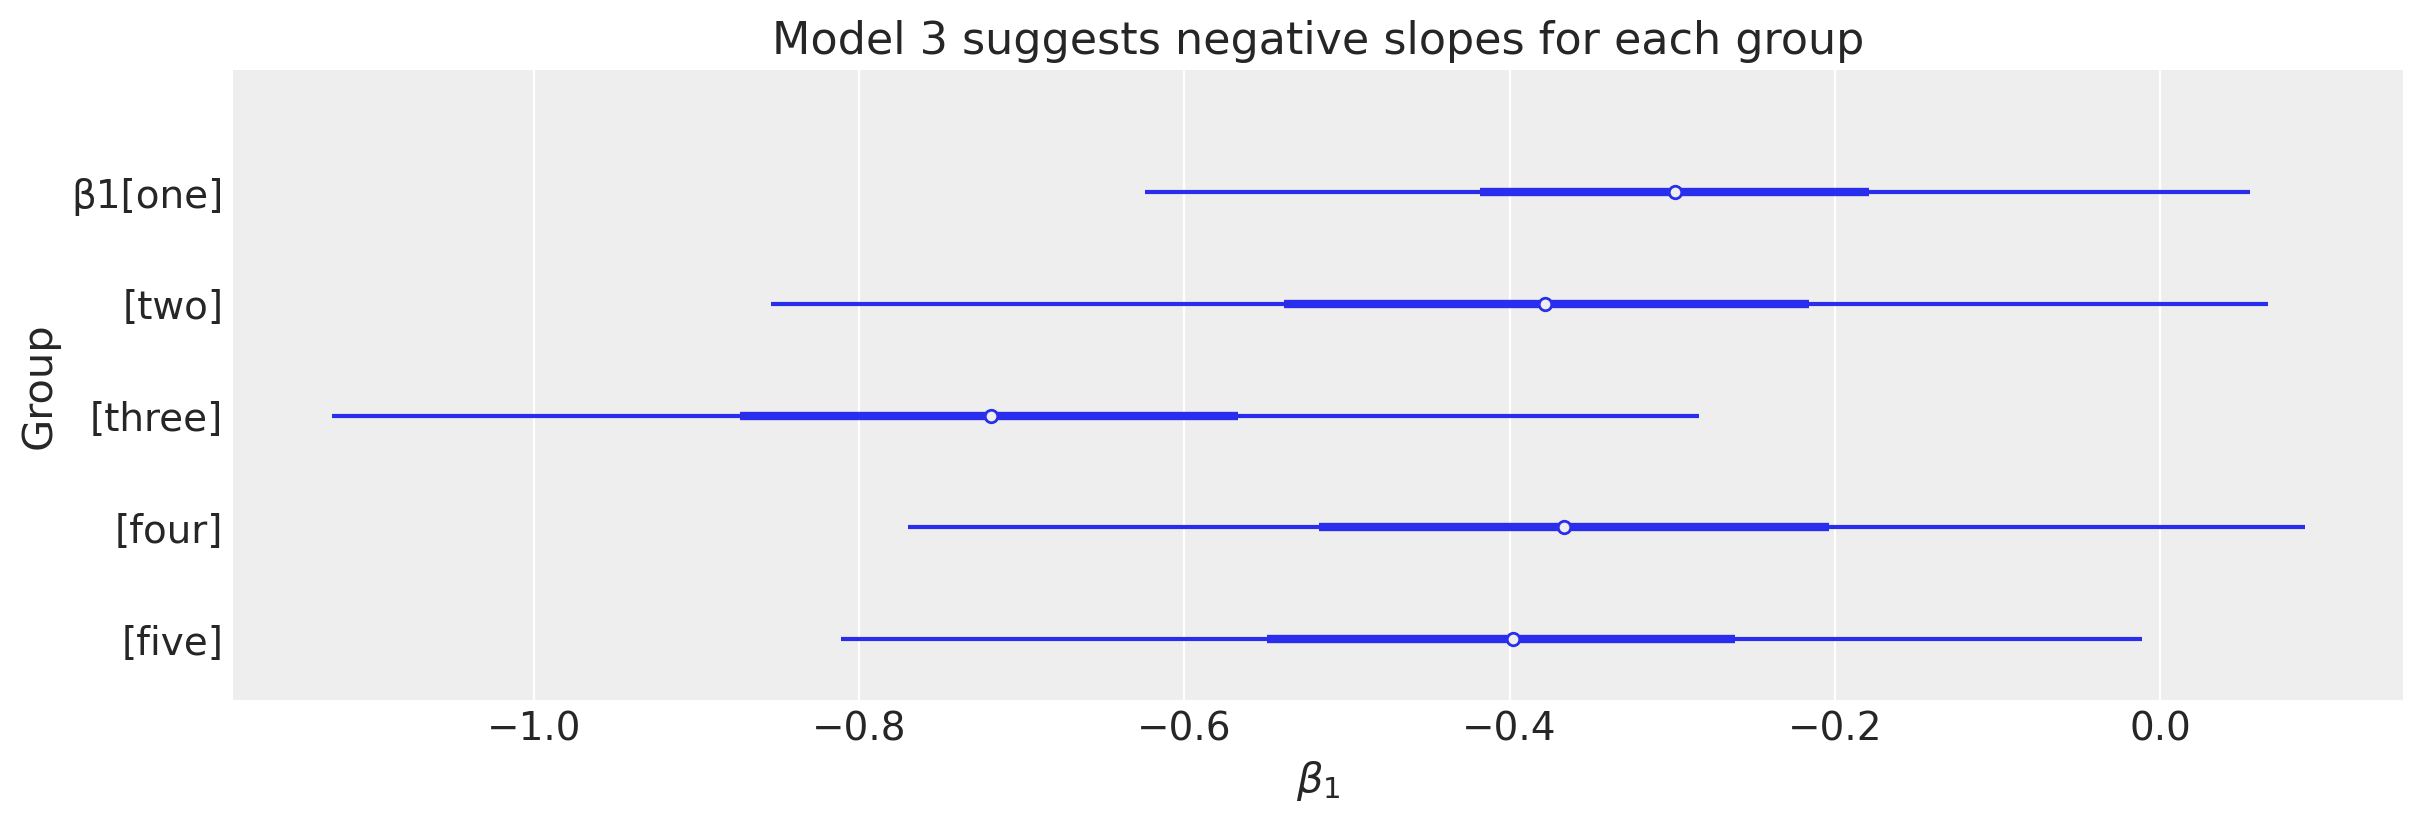

In [29]:
ax = az.plot_forest(idata2.posterior["β1"], combined=True, figsize=figsize)[0]
ax.set(title="Model 3 suggests negative slopes for each group", xlabel=r"$\beta_1$", ylabel="Group");

## Summary
Using Simpson's paradox, we've walked through 3 different models. The first is a simple linear regression which treats all the data as coming from one group. This amounts to a causal DAG asserting that $x$ causally influences $y$ and $\text{group}$ was ignored (i.e. assumed to be causally unrelated to $x$ or $y$). We saw that this lead us to believe the regression slope was positive.

While that is not necessarily wrong, it is paradoxical when we see that the regression slopes for the data _within_ a group is negative. 

This paradox is resolved by updating our causal DAG to include the group variable. This is what we did in the second and third models. Model 2 was an unpooled model where we essentially fit separate regressions for each group.

Model 3 assumed the same causal DAG, but adds the knowledge that each of these groups are sampled from an overall population. This added the ability to make inferences not only about the regression parameters at the group level, but also at the population level.

## Authors
* Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in July 2021
* Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) in April 2022
* Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) in February 2023 to run on PyMC v5
* Updated to use `az.extract` by [Benjamin T. Vincent](https://github.com/drbenvincent) in February 2023 ([pymc-examples#522](https://github.com/pymc-devs/pymc-examples/pull/522))
* Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) in September 2024 ([pymc-examples#697](https://github.com/pymc-devs/pymc-examples/pull/697) and [pymc-examples#709](https://github.com/pymc-devs/pymc-examples/pull/709))

## Watermark

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Sun Sep 22 2024

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.27.0

pytensor: 2.25.4
xarray  : 2024.9.0

matplotlib: 3.9.2
arviz     : 0.19.0
pymc      : 5.16.2
numpy     : 1.26.4
xarray    : 2024.9.0
graphviz  : 0.20.3
pandas    : 2.2.3
seaborn   : 0.13.2

Watermark: 2.5.0



:::{include} ../page_footer.md
:::